# Importing Libraries

**For Loading and Pre-processing Data**

In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from collections import Counter
from torch.utils.data import Subset

**For Data Visualization**

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

**For Model**

In [3]:
import torch.nn as nn
import torch.optim as optim

**For Evaluation**

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

**For Optimization**

In [5]:
from skopt.space import Real
from skopt import gp_minimize

**For Results**

In [6]:
from sklearn.metrics import classification_report

**For K-Fold Validation**

In [80]:
from sklearn.model_selection import KFold

# Set-up

In [7]:
seed = 12
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directories

In [9]:
currentDirectory = os.getcwd()

In [10]:
baseDirectory = os.path.join(currentDirectory, 'brainTumour')

In [11]:
trainingDirectory = os.path.join(baseDirectory, 'Training').replace("\\", "/")
testingDirectory = os.path.join(baseDirectory, 'Testing').replace("\\", "/")

# Variables

**Defining the target class**

In [12]:
categories = ["glioma", "meningioma", "notumor", "pituitary"]

**Defining image size**

In [13]:
imageSize = (256, 256)

**Defining epochs**

In [14]:
epochs = 25

# Data Loading and Pre-Processing

**Data augmentations of Training data**

In [15]:
trainDataTransform = transforms.Compose([
    transforms.RandomResizedCrop(imageSize),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

**Normalizing Testing Data**

In [16]:
testDataTransform = transforms.Compose([
    transforms.Resize(imageSize),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

**Loading Data**

In [17]:
trainData = ImageFolder(trainingDirectory, transform=trainDataTransform)
testData = ImageFolder(testingDirectory, transform=testDataTransform)

**Handling Class Imbalance**

***Check the class distribution in the training data***

In [18]:
classCounts = Counter(trainData.targets)
print("Class distribution before Class Balancing:", classCounts)

Class distribution before Class Balancing: Counter({2: 1595, 3: 1457, 1: 1339, 0: 1321})


***Determining the size of the smallest class (the minority class)***

In [19]:
minClassSize = min(classCounts.values())

***Handling Class Imbalance through Undersampling Technique***

In [20]:
undersampledIndices = []
for classLabel in classCounts:
    indices = [i for i, label in enumerate(trainData.targets) if label == classLabel]
    undersampledIndices.extend(np.random.choice(indices, minClassSize, replace = False))

***Creating a Subset of the training data with the undersampled indices***

In [21]:
balancedTrainData = Subset(trainData, undersampledIndices)

***Check the class distribution after Class Balancing***

In [22]:
classCountsUndersampled = Counter([trainData.targets[idx] for idx in undersampledIndices])
print("Class distribution after class balancing:", classCountsUndersampled)

Class distribution after class balancing: Counter({0: 1321, 1: 1321, 2: 1321, 3: 1321})


**Create Data Loaders**

In [23]:
trainDataLoader = DataLoader(trainData, batch_size = 32, shuffle = True, num_workers = 4)
testDataLoader = DataLoader(testData, batch_size = 32, shuffle = False, num_workers = 4)

# Exploratory Data Analysis (EDA)

**Visuals of each type of tumour**

***Function to get one image from each category***

In [24]:
def getOneImagePerCategoryFromDirs(baseDirectory, categories):
    imagesPerCategory = {}
    for category in categories:
        categoryDirectory = os.path.join(baseDirectory, category)
        for root, dirs, files in os.walk(categoryDirectory):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
                    imagePath = os.path.join(root, file)
                    image = Image.open(imagePath)
                    imagesPerCategory[category] = image
                    break
            if category in imagesPerCategory:
                break

    return imagesPerCategory

***Get one image per category from training data***

In [25]:
trainImagesPerCategoryDirs = getOneImagePerCategoryFromDirs(trainingDirectory, categories)

***Visualize one image from each category***

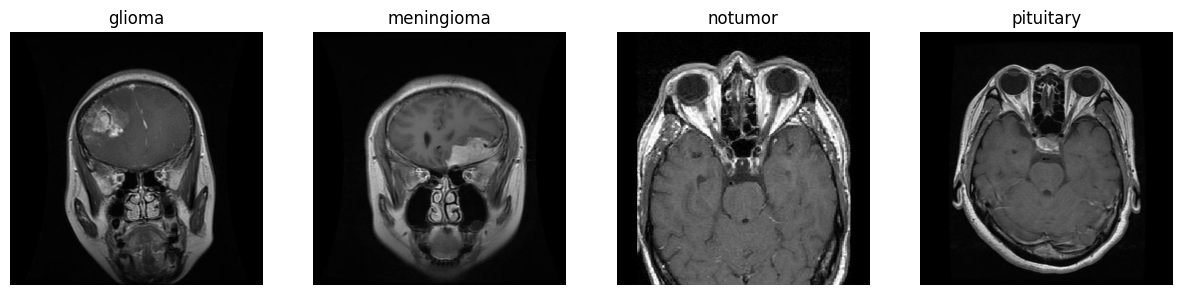

In [26]:
fig, axes = plt.subplots(1, len(categories), figsize = (15, 5))
for i, category in enumerate(categories):
    image = trainImagesPerCategoryDirs[category]
    axes[i].imshow(image)
    axes[i].set_title(category)
    axes[i].axis('off')

plt.show()

**Visualizing class distribution before class balancing**

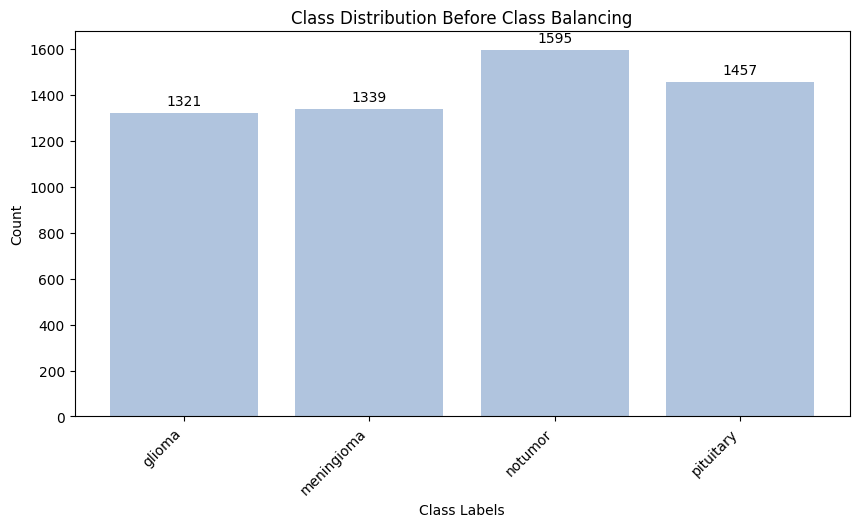

In [27]:
plt.figure(figsize=(10, 5))
bars1 = plt.bar(classCounts.keys(), classCounts.values(), color = 'lightsteelblue')
plt.title('Class Distribution Before Class Balancing')
plt.xlabel('Class Labels')
plt.ylabel('Count')

# Add labels to the bars
for index, bar in enumerate(bars1):
    height = bar.get_height()
    plt.annotate('{}'.format(height),
                 xy = (bar.get_x() + bar.get_width() / 2, height),
                 xytext = (0, 3),  # 3 points vertical offset
                 textcoords = "offset points",
                 ha = 'center', va = 'bottom')

plt.xticks(range(len(categories)), categories, rotation = 45, ha = 'right')
plt.show()

**Visualizing class distribution after class balancing**

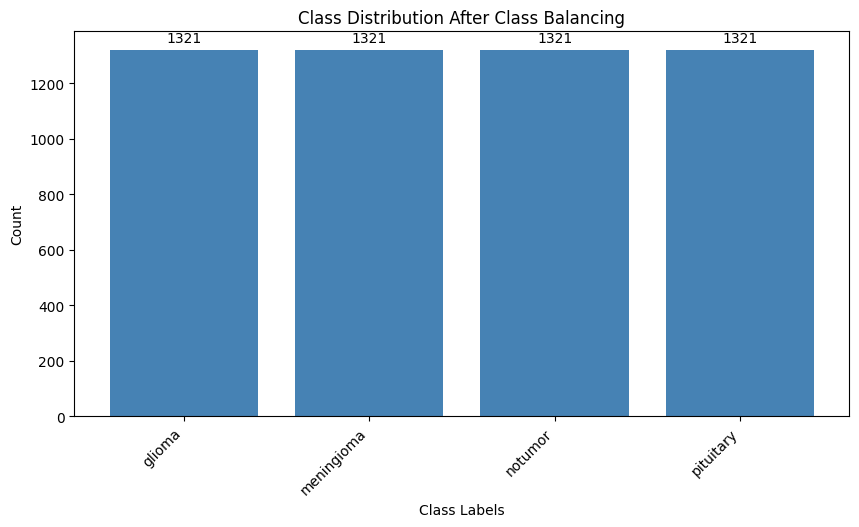

In [28]:
plt.figure(figsize = (10, 5))
bars2 = plt.bar(classCountsUndersampled.keys(), classCountsUndersampled.values(), color='steelblue')
plt.title('Class Distribution After Class Balancing')
plt.xlabel('Class Labels')
plt.ylabel('Count')

# Add labels to the bars
for index, bar in enumerate(bars2):
    height = bar.get_height()
    plt.annotate('{}'.format(height),
                 xy = (bar.get_x() + bar.get_width() / 2, height),
                 xytext = (0, 3),  # 3 points vertical offset
                 textcoords = "offset points",
                 ha = 'center', va = 'bottom')

plt.xticks(range(len(categories)), categories, rotation = 45, ha = 'right')
plt.show()

# Experiment 1: Base CNN Model

**Define the CNN model**

In [29]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 16 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

**Create the model instance**

In [30]:
model = CNNModel(num_classes=len(categories))
model.to(device)

CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)

**Define the loss function and optimizer**

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Training CNN Model**

In [32]:
lossValuesOfBaseCNN = []
accuracyValuesOfBaseCNN = []
for epoch in range(epochs):
    model.train()
    runningLoss = 0.0
    correctPredictions = 0
    totalPredictions = 0
    for inputs, labels in trainDataLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
        _, predicted = torch.max(outputs, 1)
        totalPredictions += labels.size(0)
        correctPredictions += (predicted == labels).sum().item()
        
    # Calculate average loss for the epoch
    averageLossOfBaseCNN = runningLoss / len(trainDataLoader)
    lossValuesOfBaseCNN.append(averageLossOfBaseCNN)
    
    # Calculate accuracy for the epoch
    accuracy = correctPredictions / totalPredictions
    accuracyValuesOfBaseCNN.append(accuracy)
    
    # Print training loss after each epoch
    print(f"CNN Model - Epoch {epoch+1}/{epochs}, Loss: {averageLossOfBaseCNN}, Accuracy: {accuracy}")

CNN Model - Epoch 1/25, Loss: 1.0325013705472041, Accuracy: 0.563375350140056
CNN Model - Epoch 2/25, Loss: 0.9104021701066853, Accuracy: 0.6299019607843137
CNN Model - Epoch 3/25, Loss: 0.8524598452631987, Accuracy: 0.6528361344537815
CNN Model - Epoch 4/25, Loss: 0.7830381638177947, Accuracy: 0.6853991596638656
CNN Model - Epoch 5/25, Loss: 0.7769213290520887, Accuracy: 0.6875
CNN Model - Epoch 6/25, Loss: 0.7428159374098539, Accuracy: 0.7015056022408963
CNN Model - Epoch 7/25, Loss: 0.7544771847445205, Accuracy: 0.7058823529411765
CNN Model - Epoch 8/25, Loss: 0.6972354550601384, Accuracy: 0.7233893557422969
CNN Model - Epoch 9/25, Loss: 0.6750964169395702, Accuracy: 0.728641456582633
CNN Model - Epoch 10/25, Loss: 0.6679996495140331, Accuracy: 0.738795518207283
CNN Model - Epoch 11/25, Loss: 0.6355697680785003, Accuracy: 0.7464985994397759
CNN Model - Epoch 12/25, Loss: 0.6262191202720451, Accuracy: 0.7514005602240896
CNN Model - Epoch 13/25, Loss: 0.6015541248814353, Accuracy: 0.7

**Validating CNN Model**

In [33]:
model.eval()
correct = 0
total = 0
predictedLabelsOfBaseModel = []
trueLabelsOfBaseModel = []
with torch.no_grad():
    for inputs, labels in testDataLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Save predicted and true labels for calculating metrics
        predictedLabelsOfBaseModel.extend(predicted.cpu().numpy())
        trueLabelsOfBaseModel.extend(labels.cpu().numpy())

**Evaluating the CNN**

***Accuracy of Base Model***

In [34]:
accuracyOfBaseModel = accuracy_score(trueLabelsOfBaseModel, predictedLabelsOfBaseModel)
print(f"Accuracy of CNN Model: {accuracyOfBaseModel*100}")

Accuracy of CNN Model: 82.6086956521739


***Confusion Metrics of Base Model***

In [35]:
confusionMatrixOfBaseModel = confusion_matrix(trueLabelsOfBaseModel, predictedLabelsOfBaseModel)

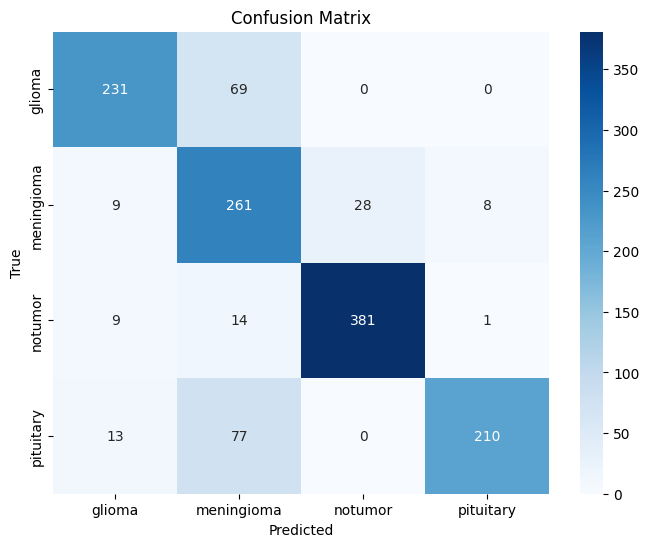

In [36]:
plt.figure(figsize = (8, 6))
sns.heatmap(confusionMatrixOfBaseModel, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

***Accuracy per Class of Base Model***

In [37]:
accuracyPerClassOFBaseModel = confusionMatrixOfBaseModel.diagonal() / confusionMatrixOfBaseModel.sum(axis=1)
for idx, category in enumerate(categories):
    print(f"Accuracy for {category}: {accuracyPerClassOFBaseModel[idx] * 100:.2f}%")

Accuracy for glioma: 77.00%
Accuracy for meningioma: 85.29%
Accuracy for notumor: 94.07%
Accuracy for pituitary: 70.00%


***Sensitivity (Recall) and Specificity for each class of Base Model***

In [38]:
for idx, category in enumerate(categories):
    TP = confusionMatrixOfBaseModel[idx, idx]
    FN = np.sum(confusionMatrixOfBaseModel[idx, :]) - TP
    FP = np.sum(confusionMatrixOfBaseModel[:, idx]) - TP
    TN = np.sum(confusionMatrixOfBaseModel) - TP - FN - FP
    
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    
    print(f"Class: {category}")
    print(f"Sensitivity: {sensitivity * 100:.2f}%")
    print(f"Specificity: {specificity * 100:.2f}%")
    print()

Class: glioma
Sensitivity: 77.00%
Specificity: 96.93%

Class: meningioma
Sensitivity: 85.29%
Specificity: 84.08%

Class: notumor
Sensitivity: 94.07%
Specificity: 96.91%

Class: pituitary
Sensitivity: 70.00%
Specificity: 99.11%



***Plot of Base Model Loss Function***

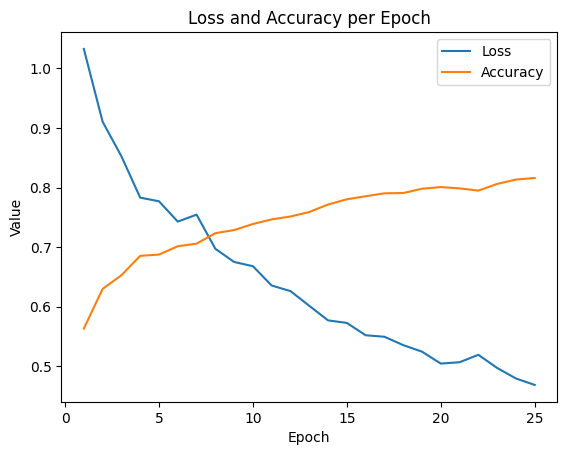

In [39]:
plt.plot(range(1, epochs + 1), lossValuesOfBaseCNN, label='Loss')
plt.plot(range(1, epochs + 1), accuracyValuesOfBaseCNN, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss and Accuracy per Epoch')
plt.legend()
plt.show()

***Classification Report of Base Model***

In [40]:
print("Classification Report of Base Model:")
print(classification_report(trueLabelsOfBaseModel, predictedLabelsOfBaseModel, target_names=categories))

Classification Report of Base Model:
              precision    recall  f1-score   support

      glioma       0.88      0.77      0.82       300
  meningioma       0.62      0.85      0.72       306
     notumor       0.93      0.94      0.94       405
   pituitary       0.96      0.70      0.81       300

    accuracy                           0.83      1311
   macro avg       0.85      0.82      0.82      1311
weighted avg       0.85      0.83      0.83      1311



# Experiment 2: Pruning Base CNN Model

**Function to prune CNN Model**

In [41]:
def pruneModel(model, pruningRatio):
    allParameters = []
    for paramName, param in model.named_parameters():
        if 'weight' in paramName:  # Only prune weights, not biases
            allParameters.append((paramName, param.data.view(-1)))

    # Flatten and concatenate all weights
    allWeights = torch.cat([param for _, param in allParameters])

    # Calculate the threshold value for pruning
    numParamsToPrune = int(pruningRatio * len(allWeights))
    threshold = torch.topk(torch.abs(allWeights), numParamsToPrune).values.min()

    # Apply pruning mask to each parameter tensor
    for paramName, param in allParameters:
        mask = torch.abs(param) > threshold
        param.data *= mask.float()

    print(f"Pruning {pruningRatio*100:.2f}% of model parameters.")

    return model

In [42]:
def getPrunedModel(originalModel, pruningRatio):
    # Create a new model instance
    prunedModel = CNNModel(num_classes=len(categories))
    prunedModel.to(device)

    # Load the state_dict from the original model to the new model
    prunedModel.load_state_dict(originalModel.state_dict())

    # Apply pruning to the new model
    prunedModel = pruneModel(prunedModel, pruningRatio)

    return prunedModel

**Pruning Ratio**

In [43]:
pruningRatio = 0.25

**Pruned CNN Model**

In [44]:
prunedModel = getPrunedModel(model, pruningRatio)

Pruning 25.00% of model parameters.


**Define the loss function and optimizer**

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(prunedModel.parameters(), lr=0.001)

**Training Pruned CNN Model**

In [46]:
lossValuesOfPrunedModel = []
accuracyValuesOfPrunedModel = []
for epoch in range(epochs):
    prunedModel.train()
    runningLoss = 0.0
    correctPredictions = 0
    totalPredictions = 0
    for inputs, labels in trainDataLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = prunedModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
        _, predicted = torch.max(outputs, 1)
        totalPredictions += labels.size(0)
        correctPredictions += (predicted == labels).sum().item()
        
    # Calculate average loss for the epoch
    averageLossOfPrunedModel = runningLoss / len(trainDataLoader)
    lossValuesOfPrunedModel.append(averageLossOfPrunedModel)
    
    # Calculate accuracy for the epoch
    accuracy = correctPredictions / totalPredictions
    accuracyValuesOfPrunedModel.append(accuracy)
    
    # Print training loss after each epoch
    print(f"Pruned Model - Epoch {epoch+1}/{epochs}, Loss: {averageLossOfPrunedModel}, Accuracy: {accuracy}")

Pruned Model - Epoch 1/25, Loss: 0.46539476896797477, Accuracy: 0.8165266106442577
Pruned Model - Epoch 2/25, Loss: 0.47740997948460073, Accuracy: 0.819327731092437
Pruned Model - Epoch 3/25, Loss: 0.4669632182440944, Accuracy: 0.8196778711484594
Pruned Model - Epoch 4/25, Loss: 0.4577670605988476, Accuracy: 0.8233543417366946
Pruned Model - Epoch 5/25, Loss: 0.4555280364258995, Accuracy: 0.8230042016806722
Pruned Model - Epoch 6/25, Loss: 0.45719869601326946, Accuracy: 0.8203781512605042
Pruned Model - Epoch 7/25, Loss: 0.4525476869757615, Accuracy: 0.8282563025210085
Pruned Model - Epoch 8/25, Loss: 0.43366806358931453, Accuracy: 0.8286064425770309
Pruned Model - Epoch 9/25, Loss: 0.44977271273815433, Accuracy: 0.8298319327731093
Pruned Model - Epoch 10/25, Loss: 0.4350109634785679, Accuracy: 0.8270308123249299
Pruned Model - Epoch 11/25, Loss: 0.432589369945686, Accuracy: 0.8366596638655462
Pruned Model - Epoch 12/25, Loss: 0.43871646828158606, Accuracy: 0.8261554621848739
Pruned Mo

**Validating Prune CNN Model**

In [47]:
prunedModel.eval()
correct = 0
total = 0
predictedLabelsOfPrunedModel = []
trueLabelsOfPrunedModel = []
with torch.no_grad():
    for inputs, labels in testDataLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = prunedModel(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Save predicted and true labels for calculating metrics
        predictedLabelsOfPrunedModel.extend(predicted.cpu().numpy())
        trueLabelsOfPrunedModel.extend(labels.cpu().numpy())

**Evaluating the Pruned CNN**

***Accuracy of Pruned Model***

In [48]:
accuracyOfPrunedModel = accuracy_score(trueLabelsOfPrunedModel, predictedLabelsOfPrunedModel)
print(f"Accuracy of Pruned CNN: {accuracyOfPrunedModel*100}")

Accuracy of Pruned CNN: 86.34630053394355


***Confusion Metrics of Pruned Model***

In [49]:
confusionMatrixOfPrunedModel = confusion_matrix(trueLabelsOfPrunedModel, predictedLabelsOfPrunedModel)

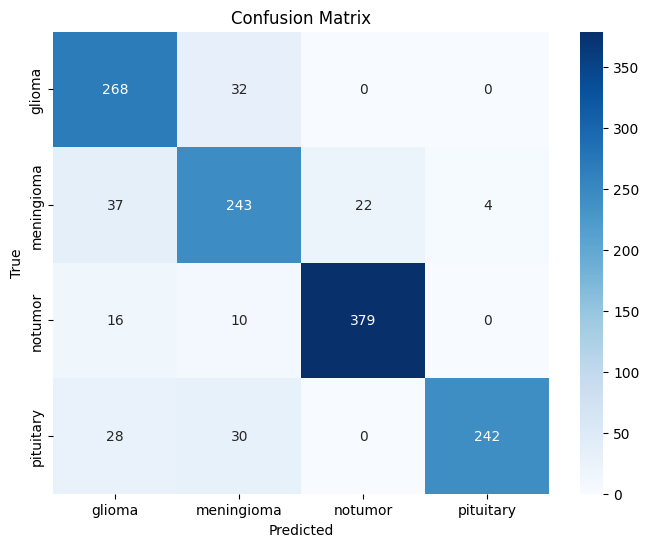

In [50]:
plt.figure(figsize = (8, 6))
sns.heatmap(confusionMatrixOfPrunedModel, annot = True, fmt = "d", cmap = "Blues", xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

***Accuracy per class of Pruned Model***

In [51]:
accuracyPerClassOfPrunedModel = confusionMatrixOfPrunedModel.diagonal() / confusionMatrixOfPrunedModel.sum(axis=1)
for idx, category in enumerate(categories):
    print(f"Accuracy for {category}: {accuracyPerClassOfPrunedModel[idx] * 100:.2f}%")

Accuracy for glioma: 89.33%
Accuracy for meningioma: 79.41%
Accuracy for notumor: 93.58%
Accuracy for pituitary: 80.67%


***Sensitivity (Recall) and Specificity for each class of Pruned Model***

In [52]:
for idx, category in enumerate(categories):
    TP = confusionMatrixOfPrunedModel[idx, idx]
    FN = np.sum(confusionMatrixOfPrunedModel[idx, :]) - TP
    FP = np.sum(confusionMatrixOfPrunedModel[:, idx]) - TP
    TN = np.sum(confusionMatrixOfPrunedModel) - TP - FN - FP
    
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    
    print(f"Class: {category}")
    print(f"Sensitivity: {sensitivity * 100:.2f}%")
    print(f"Specificity: {specificity * 100:.2f}%")
    print()

Class: glioma
Sensitivity: 89.33%
Specificity: 91.99%

Class: meningioma
Sensitivity: 79.41%
Specificity: 92.84%

Class: notumor
Sensitivity: 93.58%
Specificity: 97.57%

Class: pituitary
Sensitivity: 80.67%
Specificity: 99.60%



***Plot of Pruned Model Loss Function***

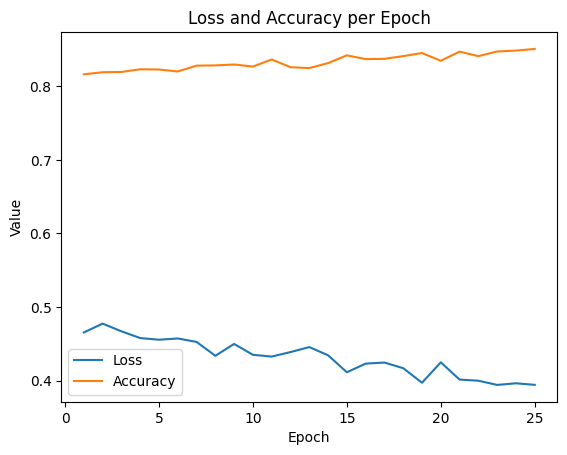

In [53]:
plt.plot(range(1, epochs + 1), lossValuesOfPrunedModel, label = 'Loss')
plt.plot(range(1, epochs + 1), accuracyValuesOfPrunedModel, label = 'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss and Accuracy per Epoch')
plt.legend()
plt.show()

***Classification Report of Pruned Model***

In [54]:
print("Classification Report of Pruned Model:")
print(classification_report(trueLabelsOfPrunedModel, predictedLabelsOfPrunedModel, target_names = categories))

Classification Report of Pruned Model:
              precision    recall  f1-score   support

      glioma       0.77      0.89      0.83       300
  meningioma       0.77      0.79      0.78       306
     notumor       0.95      0.94      0.94       405
   pituitary       0.98      0.81      0.89       300

    accuracy                           0.86      1311
   macro avg       0.87      0.86      0.86      1311
weighted avg       0.87      0.86      0.87      1311



# Experiment 3: Optimizing Pruned CNN

**Define the objective function to be minimized**

In [55]:
def objectiveFunction(params):
    pruningRatio = params[0]  # Extract the pruning_ratio from the list of params
    prunedModel = getPrunedModel(model, pruningRatio)
    
    # Define the loss function and optimizer for the pruned model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(prunedModel.parameters(), lr=0.001)

    # Training loop for the pruned model
    for epoch in range(epochs):
        prunedModel.train()
        runningLoss = 0.0
        for inputs, labels in trainDataLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = prunedModel(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            runningLoss += loss.item()
        
        # Print training loss after each epoch
        print(f"Model - Epoch {epoch+1}/{epochs}, Loss: {runningLoss/len(trainDataLoader)}")

    prunedModel.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testDataLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = prunedModel(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return -accuracy

**Define the search space for pruning ratio**

In [56]:
searchSpace = Real(low = 0.01, high = 0.5, prior = 'log-uniform')

**Performing Optimization**

In [57]:
result = gp_minimize(objectiveFunction, dimensions = [searchSpace], n_calls = 10, random_state = seed)

Pruning 5.73% of model parameters.
Model - Epoch 1/25, Loss: 0.5892364842265678
Model - Epoch 2/25, Loss: 0.5364526718355423
Model - Epoch 3/25, Loss: 0.5097619716348595
Model - Epoch 4/25, Loss: 0.4975171305613811
Model - Epoch 5/25, Loss: 0.4850641134397944
Model - Epoch 6/25, Loss: 0.4790598141580987
Model - Epoch 7/25, Loss: 0.47152438626609033
Model - Epoch 8/25, Loss: 0.4652875602744811
Model - Epoch 9/25, Loss: 0.4367502963576237
Model - Epoch 10/25, Loss: 0.45548720624526784
Model - Epoch 11/25, Loss: 0.45168214412041885
Model - Epoch 12/25, Loss: 0.44317497729256167
Model - Epoch 13/25, Loss: 0.44263592553871306
Model - Epoch 14/25, Loss: 0.441165709961726
Model - Epoch 15/25, Loss: 0.4215527792882653
Model - Epoch 16/25, Loss: 0.4343607478967592
Model - Epoch 17/25, Loss: 0.42551022193618326
Model - Epoch 18/25, Loss: 0.4083930191547511
Model - Epoch 19/25, Loss: 0.4361401241501616
Model - Epoch 20/25, Loss: 0.41455301430138797
Model - Epoch 21/25, Loss: 0.4173240977958594
Mo

Model - Epoch 25/25, Loss: 0.40283205018862667
Pruning 1.38% of model parameters.
Model - Epoch 1/25, Loss: 0.895072965981574
Model - Epoch 2/25, Loss: 0.6952690145822876
Model - Epoch 3/25, Loss: 0.6308960455089974
Model - Epoch 4/25, Loss: 0.6147176483489948
Model - Epoch 5/25, Loss: 0.5709663970843374
Model - Epoch 6/25, Loss: 0.5731736981002978
Model - Epoch 7/25, Loss: 0.5328214901952104
Model - Epoch 8/25, Loss: 0.5435901692126717
Model - Epoch 9/25, Loss: 0.51564280705412
Model - Epoch 10/25, Loss: 0.533572947179805
Model - Epoch 11/25, Loss: 0.49387755290756014
Model - Epoch 12/25, Loss: 0.5024728638499809
Model - Epoch 13/25, Loss: 0.4929662657350135
Model - Epoch 14/25, Loss: 0.4956358464736512
Model - Epoch 15/25, Loss: 0.4747109100971808
Model - Epoch 16/25, Loss: 0.47452341985769114
Model - Epoch 17/25, Loss: 0.48004493075709104
Model - Epoch 18/25, Loss: 0.4554480215191175
Model - Epoch 19/25, Loss: 0.4720986280694354
Model - Epoch 20/25, Loss: 0.4477485825396117
Model - 

**Optimal pruning ratio and corresponding accuracy**

In [58]:
optimalPruningRatio = result.x[0]
bestAccuracy = -result.fun

In [59]:
print("Optimal Pruning Ratio:", optimalPruningRatio)
print("Best Test Accuracy: {:.2f}%".format(bestAccuracy))

Optimal Pruning Ratio: 0.04299664467712531
Best Test Accuracy: 88.48%


**Optimised Prune Model**

In [60]:
optimisedPrunedModel = getPrunedModel(model, optimalPruningRatio)

Pruning 4.30% of model parameters.


**Define the loss function and optimizer**

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(optimisedPrunedModel.parameters(), lr=0.001)

**Training Optimised Pruned CNN Model**

In [62]:
lossValuesOfOptimisedPrunedModel = []
accuracyValuesOfOptimisedPrunedModel = []
for epoch in range(epochs):
    optimisedPrunedModel.train()
    runningLoss = 0.0
    correctPredictions = 0
    totalPredictions = 0
    for inputs, labels in trainDataLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = optimisedPrunedModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
        _, predicted = torch.max(outputs, 1)
        totalPredictions += labels.size(0)
        correctPredictions += (predicted == labels).sum().item()
        
    # Calculate average loss for the epoch
    averageLossOfOptimisedPrunedModel = runningLoss / len(trainDataLoader)
    lossValuesOfOptimisedPrunedModel.append(averageLossOfOptimisedPrunedModel)
    
    # Calculate accuracy for the epoch
    accuracy = correctPredictions / totalPredictions
    accuracyValuesOfOptimisedPrunedModel.append(accuracy)
    
    # Print training loss after each epoch
    print(f"Optimised Pruned Model - Epoch {epoch+1}/{epochs}, Loss: {averageLossOfOptimisedPrunedModel}, Accuracy: {accuracy}")

Optimised Pruned Model - Epoch 1/25, Loss: 0.6603888184997623, Accuracy: 0.7415966386554622
Optimised Pruned Model - Epoch 2/25, Loss: 0.5465547452425824, Accuracy: 0.7836134453781513
Optimised Pruned Model - Epoch 3/25, Loss: 0.5156361370779282, Accuracy: 0.803921568627451
Optimised Pruned Model - Epoch 4/25, Loss: 0.5106496816740356, Accuracy: 0.805672268907563
Optimised Pruned Model - Epoch 5/25, Loss: 0.499402650324992, Accuracy: 0.8065476190476191
Optimised Pruned Model - Epoch 6/25, Loss: 0.49255369170750984, Accuracy: 0.8146008403361344
Optimised Pruned Model - Epoch 7/25, Loss: 0.464051609765218, Accuracy: 0.820203081232493
Optimised Pruned Model - Epoch 8/25, Loss: 0.4688791687595112, Accuracy: 0.8195028011204482
Optimised Pruned Model - Epoch 9/25, Loss: 0.45943277599758275, Accuracy: 0.8254551820728291
Optimised Pruned Model - Epoch 10/25, Loss: 0.4653227074519216, Accuracy: 0.8182773109243697
Optimised Pruned Model - Epoch 11/25, Loss: 0.44759804335053405, Accuracy: 0.82668

**Validating Optimised Pruned CNN Model**

In [63]:
optimisedPrunedModel.eval()
correct = 0
total = 0
predictedLabelsOfOptimisedPrunedModel = []
trueLabelsOfOptimisedPrunedModel = []
with torch.no_grad():
    for inputs, labels in testDataLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = optimisedPrunedModel(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Save predicted and true labels for calculating metrics
        predictedLabelsOfOptimisedPrunedModel.extend(predicted.cpu().numpy())
        trueLabelsOfOptimisedPrunedModel.extend(labels.cpu().numpy())

**Evaluating the Optimised Pruned CNN**

***Accuracy of Optimised Pruned Model***

In [64]:
accuracyOfOptimisedPrunedModel = accuracy_score(trueLabelsOfOptimisedPrunedModel, predictedLabelsOfOptimisedPrunedModel)
print(f"Accuracy of Optimised Pruned CNN: {accuracyOfOptimisedPrunedModel*100}")

Accuracy of Optimised Pruned CNN: 87.26163234172387


***Confusion Metrics of Optimised Pruned Model***

In [65]:
confusionMatrixOfOptimisedPrunedModel = confusion_matrix(trueLabelsOfOptimisedPrunedModel, predictedLabelsOfOptimisedPrunedModel)

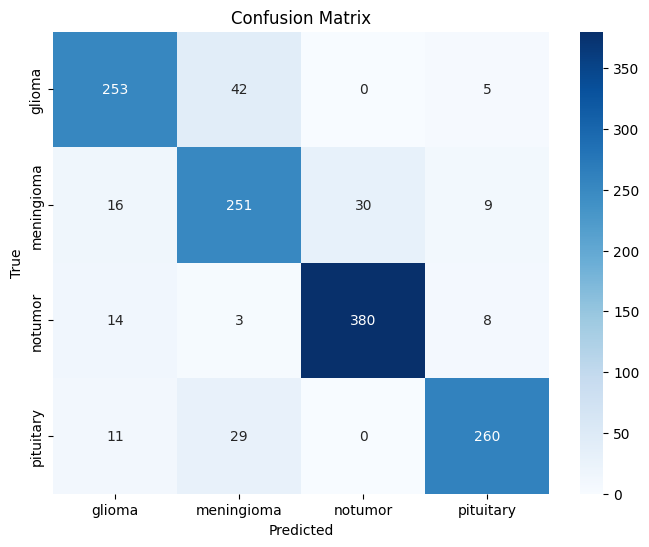

In [66]:
plt.figure(figsize = (8, 6))
sns.heatmap(confusionMatrixOfOptimisedPrunedModel, annot = True, fmt = "d", cmap = "Blues", xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

***Accuracy per Class of Optimised Pruned Model***

In [67]:
accuracyPerClassOfOptimisedPrunedModel = confusionMatrixOfOptimisedPrunedModel.diagonal() / confusionMatrixOfOptimisedPrunedModel.sum(axis = 1)
for idx, category in enumerate(categories):
    print(f"Accuracy for {category}: {accuracyPerClassOfOptimisedPrunedModel[idx] * 100:.2f}%")

Accuracy for glioma: 84.33%
Accuracy for meningioma: 82.03%
Accuracy for notumor: 93.83%
Accuracy for pituitary: 86.67%


***Sensitivity (Recall) and Specificity for each class of Optimised Pruned Model***

In [68]:
for idx, category in enumerate(categories):
    TP = confusionMatrixOfOptimisedPrunedModel[idx, idx]
    FN = np.sum(confusionMatrixOfOptimisedPrunedModel[idx, :]) - TP
    FP = np.sum(confusionMatrixOfOptimisedPrunedModel[:, idx]) - TP
    TN = np.sum(confusionMatrixOfOptimisedPrunedModel) - TP - FN - FP
    
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    
    print(f"Class: {category}")
    print(f"Sensitivity: {sensitivity * 100:.2f}%")
    print(f"Specificity: {specificity * 100:.2f}%")
    print()

Class: glioma
Sensitivity: 84.33%
Specificity: 95.94%

Class: meningioma
Sensitivity: 82.03%
Specificity: 92.64%

Class: notumor
Sensitivity: 93.83%
Specificity: 96.69%

Class: pituitary
Sensitivity: 86.67%
Specificity: 97.82%



***Plot of Optimised Pruned Model Loss Function***

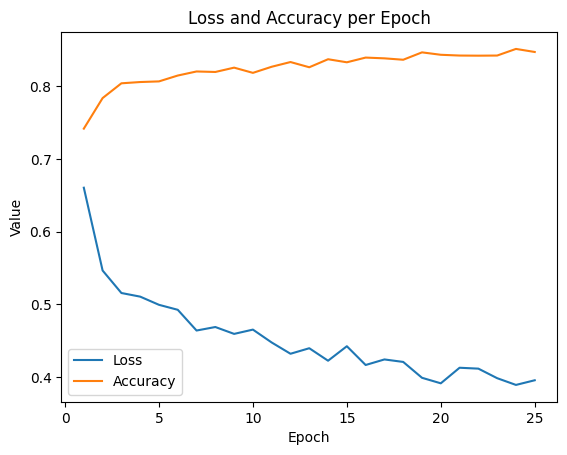

In [69]:
plt.plot(range(1, epochs + 1), lossValuesOfOptimisedPrunedModel, label = 'Loss')
plt.plot(range(1, epochs + 1), accuracyValuesOfOptimisedPrunedModel, label = 'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss and Accuracy per Epoch')
plt.legend()
plt.show()

***Classification Report of Optimised Pruned Model***

In [70]:
print("Classification Report of Optimised Pruned Model:")
print(classification_report(trueLabelsOfOptimisedPrunedModel, predictedLabelsOfOptimisedPrunedModel, target_names = categories))

Classification Report of Optimised Pruned Model:
              precision    recall  f1-score   support

      glioma       0.86      0.84      0.85       300
  meningioma       0.77      0.82      0.80       306
     notumor       0.93      0.94      0.93       405
   pituitary       0.92      0.87      0.89       300

    accuracy                           0.87      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.87      0.87      0.87      1311



# Experiment 4: K-Fold Validation

In [90]:
optimisedPrunedModelForKFold = getPrunedModel(model, optimalPruningRatio)

Pruning 4.30% of model parameters.


In [91]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(optimisedPrunedModelForKFold.parameters(), lr=0.001)

In [92]:
kFolds = 5

In [93]:
kf = KFold(n_splits = kFolds, shuffle = True, random_state = seed)

In [94]:
foldAccuracies = []

In [97]:
for fold, (train_index, val_index) in enumerate(kf.split(trainData)):
    print(f"Fold {fold+1}/{k_folds}")

    # Create data loaders for current fold
    trainSubset = Subset(trainData, train_index)
    valSubset = Subset(trainData, val_index)

    trainLoader = DataLoader(trainSubset, batch_size=32, shuffle=True, num_workers=4)
    valLoader = DataLoader(valSubset, batch_size=32, shuffle=False, num_workers=4)

    # Train the optimised pruned model on the current fold
    for epoch in range(epochs):
        optimisedPrunedModelForKFold.train()
        runningLoss = 0.0
        for inputs, labels in trainLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = optimisedPrunedModelForKFold(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            runningLoss += loss.item()
        
        # Print training loss after each epoch
        print(f"Optimised Pruned Model - Fold {fold+1} - Epoch {epoch+1}/{epochs}, Loss: {runningLoss/len(trainLoader)}")

    # Evaluate the optimised pruned model on the validation data for the current fold
    optimisedPrunedModelForKFold.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = optimisedPrunedModelForKFold(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    foldAccuracies.append(accuracy)

Fold 1/5
Optimised Pruned Model - Fold 1 - Epoch 1/25, Loss: 0.538657070248277
Optimised Pruned Model - Fold 1 - Epoch 2/25, Loss: 0.5314665661825166
Optimised Pruned Model - Fold 1 - Epoch 3/25, Loss: 0.5097710739274125
Optimised Pruned Model - Fold 1 - Epoch 4/25, Loss: 0.4971143947197841
Optimised Pruned Model - Fold 1 - Epoch 5/25, Loss: 0.5194447850222355
Optimised Pruned Model - Fold 1 - Epoch 6/25, Loss: 0.5129292904288618
Optimised Pruned Model - Fold 1 - Epoch 7/25, Loss: 0.4700903063053851
Optimised Pruned Model - Fold 1 - Epoch 8/25, Loss: 0.4702124409117065
Optimised Pruned Model - Fold 1 - Epoch 9/25, Loss: 0.4704268688296938
Optimised Pruned Model - Fold 1 - Epoch 10/25, Loss: 0.4510325714424773
Optimised Pruned Model - Fold 1 - Epoch 11/25, Loss: 0.4592549592464954
Optimised Pruned Model - Fold 1 - Epoch 12/25, Loss: 0.45468137439314305
Optimised Pruned Model - Fold 1 - Epoch 13/25, Loss: 0.4782102031932844
Optimised Pruned Model - Fold 1 - Epoch 14/25, Loss: 0.440078300

Optimised Pruned Model - Fold 5 - Epoch 15/25, Loss: 0.28095594246487515
Optimised Pruned Model - Fold 5 - Epoch 16/25, Loss: 0.3102363271938337
Optimised Pruned Model - Fold 5 - Epoch 17/25, Loss: 0.2965686115455794
Optimised Pruned Model - Fold 5 - Epoch 18/25, Loss: 0.29720967518282937
Optimised Pruned Model - Fold 5 - Epoch 19/25, Loss: 0.2874411417731455
Optimised Pruned Model - Fold 5 - Epoch 20/25, Loss: 0.28361205881708984
Optimised Pruned Model - Fold 5 - Epoch 21/25, Loss: 0.2849681924481492
Optimised Pruned Model - Fold 5 - Epoch 22/25, Loss: 0.2904933674873172
Optimised Pruned Model - Fold 5 - Epoch 23/25, Loss: 0.3042400340725492
Optimised Pruned Model - Fold 5 - Epoch 24/25, Loss: 0.30674604409849726
Optimised Pruned Model - Fold 5 - Epoch 25/25, Loss: 0.28958050588836204


In [99]:
meanAccuracyAfterKFoldValidation = np.mean(foldAccuracies)
print("Mean Accuracy with k-fold cross-validation:", meanAccuracyAfterKFoldValidation)

Mean Accuracy with k-fold cross-validation: 86.46777077558825


# Visualization for Comparison Between State-of-the-art and Research Framework

**Plot of Loss Function**

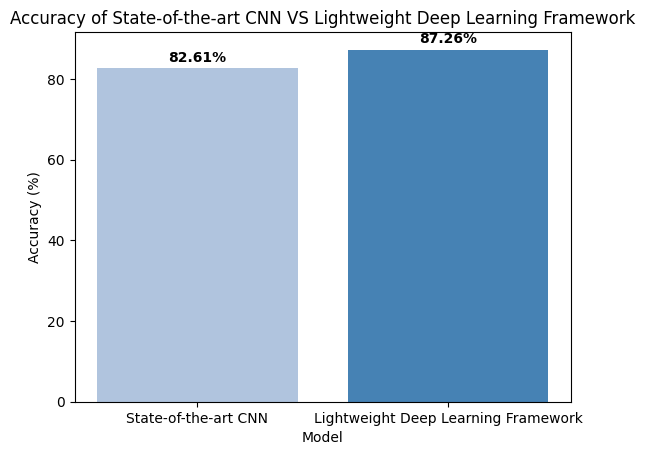

In [103]:
# List of model names and accuracy values
models = ['State-of-the-art CNN', 'Lightweight Deep Learning Framework']
accuracies = [accuracyOfBaseModel * 100, accuracyOfOptimisedPrunedModel * 100]

# Use the same colors as the previous plot
colors = ['lightsteelblue', 'steelblue']

# Create a bar plot
plt.bar(models, accuracies, color=colors)

plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of State-of-the-art CNN VS Lightweight Deep Learning Framework')

# Annotate accuracy values above the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold', color='black')

plt.show()

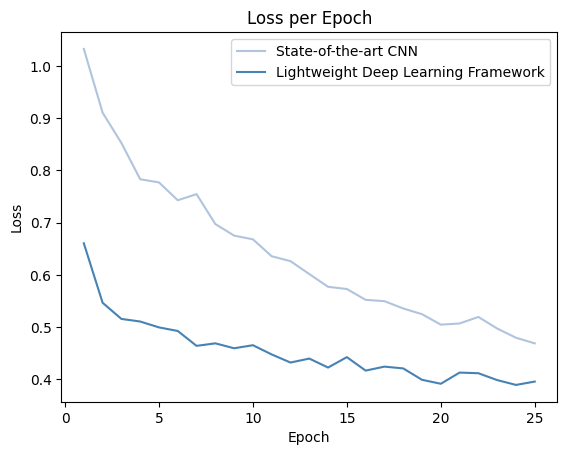

In [101]:
plt.plot(range(1, epochs + 1), lossValuesOfBaseCNN, label='State-of-the-art CNN', color='lightsteelblue')
plt.plot(range(1, epochs + 1), lossValuesOfOptimisedPrunedModel, label='Lightweight Deep Learning Framework',color='steelblue')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

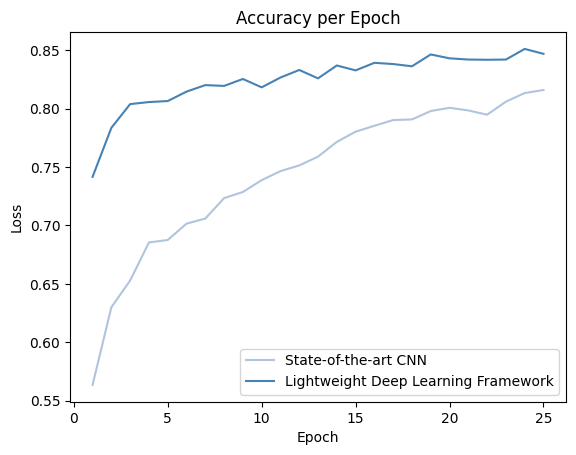

In [102]:
plt.plot(range(1, epochs + 1), accuracyValuesOfBaseCNN, label='State-of-the-art CNN', color='lightsteelblue')
plt.plot(range(1, epochs + 1), accuracyValuesOfOptimisedPrunedModel, label='Lightweight Deep Learning Framework',color='steelblue')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()